In [5]:
import numpy as np

def get_missing_coords_from_partial(c_contents, precision=6):
    """
    Parse the partial coordinate file content to find which x,y are missing.
    Returns missing_x, missing_y as 1D arrays.

    This assumes the file format has:
      1) A line 'internalField'
      2) Next line => number of points
      3) Next lines => partial coords.
    """
    lines = c_contents.splitlines()

    num_points = None
    start_index = None
    for i, line in enumerate(lines):
        if line.strip().startswith("internalField"):
            num_points = int(lines[i + 1].strip())
            start_index = i + 3
            break

    coords = []
    for line in lines[start_index:start_index + num_points]:
        line = line.strip("()\n")
        x_str, y_str, z_str = line.split()
        x, y, z = map(float, (x_str, y_str, z_str))
        coords.append((x, y, z))
    coords = np.array(coords)
    coords[:, 0] = np.round(coords[:, 0], precision)
    coords[:, 1] = np.round(coords[:, 1], precision)

    # Unique x,y
    x_unique, x_counts = np.unique(coords[:, 0], return_counts=True)
    y_unique, y_counts = np.unique(coords[:, 1], return_counts=True)

    # Expected counts
    expected_count_x = len(y_unique)
    expected_count_y = len(x_unique)

    missing_x = x_unique[x_counts < expected_count_x]
    missing_y = y_unique[y_counts < expected_count_y]

    return missing_x, missing_y


In [6]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

def plot_simulation_evolution(
    final_data_path,
    sim_data_json,
    sim_index=0,
    time_steps=None,
    output_folder="plots",
    use_partial_coords=True,
    mask_channel=None
):
    """
    Visualize the evolution of one simulation's data over selected time steps.
    
    Args:
        final_data_path (str):
            Path to 'all_sims_data.npy', shape e.g. (num_sims, num_time_steps, 128, 128, channels).
        sim_data_json (str):
            Path to 'sim_data_with_contents.json', containing an array of objects:
              [{"folder": "...", "c_contents": "..."}, ...].
        sim_index (int):
            Which simulation index in final_data to visualize.
        time_steps (list of ints, optional):
            Which time steps to plot. If None, plot all. 
        output_folder (str):
            Directory to save the resulting plots.
        use_partial_coords (bool):
            If True, parse the partial coordinate file to highlight the hole.
            If False, you can rely on a mask channel in the data (mask_channel).
        mask_channel (int or None):
            If the final channel is a mask, specify its index. 0=hole,1=valid.
            For example, if you have 5 channels, the last might be channel=4 as the mask.
            If None, the code won't parse a mask from the data. 
    """
    os.makedirs(output_folder, exist_ok=True)

    # Load final_data from npy
    final_data = np.load(final_data_path)  
    # shape => (num_sims, num_time_steps, 128, 128, channels)

    # Basic checks
    if sim_index >= final_data.shape[0]:
        raise ValueError(f"sim_index={sim_index} out of range (0..{final_data.shape[0]-1})")

    num_time_steps = final_data.shape[1]
    data_height, data_width = final_data.shape[2], final_data.shape[3]
    num_channels = final_data.shape[4]

    # If user didn't specify time_steps, plot them all
    if time_steps is None:
        time_steps = range(num_time_steps)

    # Load the partial coordinate contents from JSON
    with open(sim_data_json, "r") as jf:
        sim_info_list = json.load(jf)
    # sim_info_list is e.g. [{"folder":..., "c_contents":...}, ...]

    if sim_index >= len(sim_info_list):
        raise ValueError(
            f"sim_data JSON has only {len(sim_info_list)} entries, but sim_index={sim_index} was requested."
        )

    c_contents = sim_info_list[sim_index]["c_contents"]
    folder_name = sim_info_list[sim_index]["folder"]

    # If we want to highlight the hole using partial coords
    hole_mask = np.ones((data_height, data_width), dtype=bool)  # True=valid
    if use_partial_coords:
        missing_x, missing_y = get_missing_coords_from_partial(c_contents)
        # Build a small mapping from x->index. We'll assume coordinates are multiples of 1/128:
        # If x=0.234375 => that might be index=30 in [0..127].
        # We'll do a naive round approach: i = int(round(x * 128)) if domain=[0..1].
        # Then set hole_mask[i, j] = False for missing coords.

        for mx in missing_x:
            i = int(round(mx * data_width))
            for my in missing_y:
                j = int(round(my * data_height))
                # Ensure within bounds
                if 0 <= i < data_width and 0 <= j < data_height:
                    hole_mask[j, i] = False   # j => row (y), i => col (x)

    # If user specified a mask channel in final_data, parse it
    data = final_data[sim_index]  # shape => (num_time_steps, 128, 128, channels)
    if mask_channel is not None and mask_channel < num_channels:
        # E.g., if data[t, :, :, mask_channel]==0 => hole
        # We'll combine it with hole_mask if we want
        # The data-based mask might override partial coords or vice versa.
        for t in time_steps:
            mask_from_data = data[t, :, :, mask_channel]  # shape (128,128)
            # If mask=0 => hole => false
            # Combine with hole_mask
            hole_mask = hole_mask & (mask_from_data > 0.5)

    # Find min & max across first 4 channels over the selected time steps
    num_channels_to_plot = min(4, num_channels)

    # Initialize vmin and vmax for normalization
    vmin = np.inf
    vmax = -np.inf

    for ch in range(num_channels_to_plot):
        for t in time_steps:
            data_min = np.nanmin(data[t, :, :, ch])  # Ignore NaNs
            data_max = np.nanmax(data[t, :, :, ch])  
            vmin = min(vmin, data_min)
            vmax = max(vmax, data_max)
    # Now hole_mask[y,x]==False => hole, True => valid
    # We'll plot each requested time step
    for t in time_steps:
        # We'll plot only the first 4 channels
        num_channels_to_plot = min(4, num_channels)
        fig, axes = plt.subplots(1, num_channels_to_plot, figsize=(4*num_channels_to_plot, 5))

        if num_channels_to_plot == 1:
            axes = [axes]  # Ensure it's iterable

        # Plot only the first 4 channels
        for ch in range(num_channels_to_plot):
            channel_data = data[t, :, :, ch]  # shape => (128,128)
            # We'll blank out the hole in one of two ways:
            # e.g., we can set channel_data to np.nan in the hole:
            channel_data_hole = np.where(hole_mask, channel_data, np.nan)

            ax = axes[ch]
            im = ax.imshow(channel_data_hole, origin='lower', cmap='viridis')
            ax.set_title(f"Sim {sim_index}, Time {t}, Channel {ch}")
            ax.axis("off")

            # Set colorbar only for first 4 channels
            fig.colorbar(im, ax=ax, shrink=0.8)

        plot_name = f"sim{sim_index}_time{t}_evolution.png"
        plt.suptitle(f"Folder: {folder_name}")
        plt.tight_layout()
        plt.savefig(os.path.join(output_folder, plot_name))
        plt.close(fig)

    print(f"Plots for sim_index={sim_index} saved in '{output_folder}'.")


In [7]:
plot_simulation_evolution(
        final_data_path="all_sims_data.npy",
        sim_data_json="sim_data_with_contents.json",
        sim_index=0,
        time_steps=[0,1,2],   # or None to plot them all
        output_folder="plots",
        use_partial_coords=True,
        mask_channel=None
    )

Plots for sim_index=0 saved in 'plots'.


Loading file: /home/vhsingh/openfoam10-run/Geo-UPSplus/dataset_gen/Hole_Size_Change/CE_KH_Openfoam/all_sims_data.npy


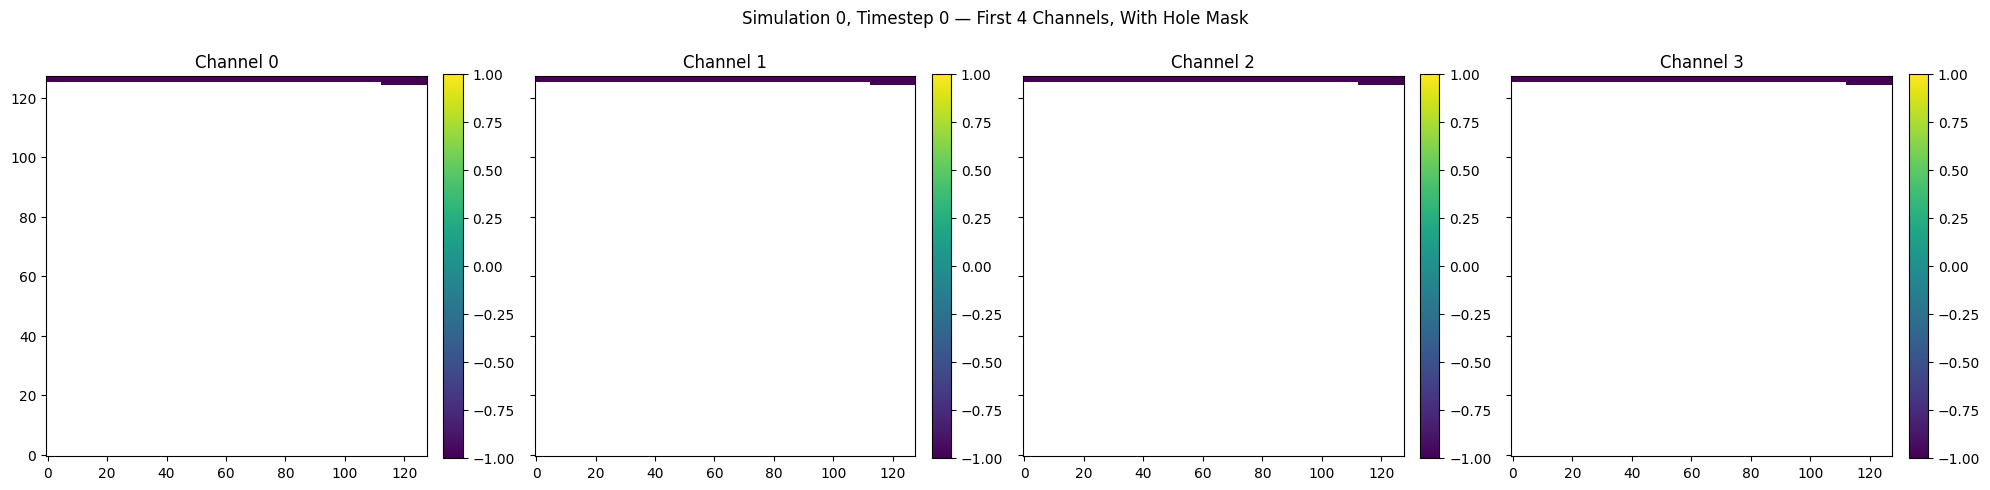

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma

def plot_first_4_channels_with_hole(
    data_file_path,
    sim_index=0,
    time_index=0,
    use_mask=True
):
    """
    Plots the first 4 channels of the final dataset (e.g. velocity, pressure, etc.),
    optionally applying the hole mask (last channel).

    Args:
        data_file_path (str): Path to your final .npy file (shape:
                              (num_sims, time_steps, 128, 128, total_channels)).
        sim_index (int): Which simulation index to visualize.
        time_index (int): Which time step index to visualize.
        use_mask (bool): If True, apply a mask so the hole appears blank;
                         if False, plot data as-is.

    Returns:
        None, but displays a matplotlib figure.
    """

    # 1) Load the dataset
    print(f"Loading file: {data_file_path}")
    final_data = np.load(data_file_path)  # shape: (num_sims, time_steps, 128, 128, total_channels)

    # 2) Extract the slice we want
    # We'll assume final_data has at least 5 channels if you store the mask in the last one
    # The first 4 channels are your physical fields
    # final_data shape => (num_sims, time_steps, 128, 128, total_channels)
    first_4_phys = final_data[sim_index, time_index, ..., 0:4]  # shape => (128, 128, 4)

    # 3) Check if we have a mask channel
    mask_channel = None
    if final_data.shape[-1] > 4 and use_mask:
        mask_channel = final_data[sim_index, time_index, ..., -1]  # shape => (128, 128)

    # 4) Create a masked array if needed
    # By default, do not mask
    masked_phys = first_4_phys

    if mask_channel is not None:
        # Expand the 2D mask to 3D so it broadcasts across 4 channels
        mask_3d = np.broadcast_to(mask_channel[..., np.newaxis], first_4_phys.shape)  # Ensures shape (128, 128, 4)
        masked_phys = ma.array(first_4_phys, mask=mask_3d)
    
    # 5) Plot each of the 4 channels
    fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharex=True, sharey=True)

    channel_names = [f"Channel {i}" for i in range(4)]
    for i in range(4):
        ax = axes[i]
        im = ax.imshow(
            masked_phys[..., i],
            origin='lower',
            cmap='viridis',
            vmin=-1,  # or -0.5
            vmax= 1   # or +0.5
        )
        ax.set_title(channel_names[i])
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    fig.suptitle(
        f"Simulation {sim_index}, Timestep {time_index} — First 4 Channels"
        + (", With Hole Mask" if mask_channel is not None else ", No Mask")
    )
    plt.tight_layout()
    plt.show()

# Example usage:
plot_first_4_channels_with_hole("/home/vhsingh/openfoam10-run/Geo-UPSplus/dataset_gen/Hole_Size_Change/CE_KH_Openfoam/all_sims_data.npy", sim_index=0, time_index=0, use_mask=True)
